<a href="https://colab.research.google.com/github/kareemullah123456789/cybersecurity_ML/blob/main/workshop_stjoseph_CIC_IDS_2017.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding SYN and ACK in Networking

When two computers talk over the internet using TCP (Transmission Control Protocol),  
they need to establish a connection first. This happens through a process called the **TCP 3-way handshake**.

---

### 🔹 Step 1: SYN (Synchronize)
- The client says: **"Hi, I want to start a connection. Here’s my sequence number."**
- This is the **SYN flag**.
- Think of it as knocking on a door.

---

### 🔹 Step 2: SYN-ACK (Synchronize + Acknowledge)
- The server replies: **"Got your request! Here’s my sequence number, and I acknowledge yours."**
- This is **SYN + ACK flags together**.
- Like someone answering the door and saying: *"Yes, I heard your knock, and I’m ready."*

---

### 🔹 Step 3: ACK (Acknowledge)
- The client replies: **"Great, I acknowledge you too. Let’s start talking."**
- This is the **ACK flag**.
- Like shaking hands after the door is opened.

---

### Why are SYN and ACK important in IDS?

- **SYN floods (DoS attack):**
  - Attacker sends thousands of SYN packets but never replies with ACK.
  - Server waits, keeping resources busy → gets overloaded.
  - Seen as **many SYN flags, few ACK flags**.

- **Normal traffic:**
  - SYN → SYN-ACK → ACK happens quickly.
  - Roughly equal numbers of SYNs and ACKs.

So:
- **SYN = start a conversation.**
- **ACK = I heard you.**

By counting SYN and ACK flags, we can detect whether connections look **normal** or like an **attack**.


# Features Used in Our Intrusion Detection Models

We selected **12 flow-level features** .  


---

### 1. destination_port
- The **port number** the traffic is trying to reach (e.g., 80 = HTTP, 443 = HTTPS, 22 = SSH).
- Attacks often target **specific services**:
  - Port 22 → SSH brute force.
  - Port 80/443 → web attacks (SQL injection, XSS, DoS).
- Helps detect **which service is under attack**.

---

### 2. flow_duration
- How long the connection lasted (in micro/milliseconds).
- **DoS attacks** → very short flows (server drops quickly).
- **Infiltration / exfiltration** → very long flows.
- Tells us about the **nature of the session**.

---

### 3. total_fwd_packets
- Number of packets sent **from client → server**.
- Abnormally high forward packets may indicate:
  - **DoS flood** (attacker sending tons of requests).
  - **Port scan** (one-way probing traffic).

---

### 4. total_backward_packets
- Number of packets sent **from server → client**.
- In normal traffic: usually balanced with forward packets.
- In attacks: often **low or missing** (server doesn’t respond properly).

---

### 5. fwd_packet_length_mean
- The **average size** of client → server packets.
- Useful for spotting:
  - **Scans / floods** (small, repetitive packets).
  - **Data uploads** (larger packets).

---

### 6. bwd_packet_length_mean
- The **average size** of server → client packets.
- In benign traffic: replies are usually larger (e.g., downloading a webpage).
- In attacks: replies may be missing, very small, or unusual in size.

---

### 7. flow_bytes_s
- **Bytes per second** in the flow.
- **High values** → possible **data exfiltration** or **DoS flood**.
- **Low values** with many packets → suspicious small-packet floods.

---

### 8. flow_packets_s
- **Packets per second** in the flow.
- **DoS/DDoS** → thousands of packets/sec.
- Normal user sessions (e.g., browsing, email) → far lower rates.

---

### 9. syn_flag_count
- Number of **SYN packets** (connection attempts).
- High SYN count without ACKs = **SYN flood attack**.
- Useful to catch attacks on the TCP handshake.

---

### 10. ack_flag_count
- Number of **ACK packets** (acknowledgments).
- In normal traffic: SYN is followed by ACK.
- In attacks: imbalance → many SYNs, few ACKs.

---

### 11. idle_mean
- Average **idle time** (no packets sent) between bursts of activity.
- Normal user browsing has **idle gaps** (waiting for clicks, server response).
- Attacks (DoS floods) often have **very little idle time**.

---

### 12. active_mean
- Average **active time** (continuous sending of packets).
- Normal traffic: short bursts, then idle.
- DoS/DDoS: long continuous active flows with no pause.

---

## Why these 12 features?
- They cover **traffic volume** (packets, bytes, duration).  
- They include **protocol behavior** (SYN/ACK flags).  
- They capture **timing patterns** (idle, active).  
- They are easy to explain to students with **real-world attack examples**.
- Together, they provide a strong **signal for distinguishing benign vs attack flows**.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
import os
import glob
import pandas as pd
import re

# Path to your MachineLearning folder in Drive
folder_path = "/content/drive/MyDrive/cybersecurity_data/MachineLearning"  # adjust if needed

# Find all .csv files
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
print(f"Found {len(csv_files)} CSV files")

# Function to clean column names
def clean_col(name):
    name = name.strip()
    name = re.sub(r"[ \t/\\\-\(\)\[\]\{\}\.:]+", "_", name)
    name = re.sub(r"_+", "_", name)
    return name.strip("_").lower()

dfs = []
for file in csv_files:
    print("Loading:", file)
    df_part = pd.read_csv(file)
    df_part.columns = [clean_col(c) for c in df_part.columns]
    df_part["_source_file"] = os.path.basename(file)  # optional trace
    dfs.append(df_part)

# Concatenate
df_all = pd.concat(dfs, ignore_index=True)
print("Combined shape:", df_all.shape)

# Preview cleaned columns
print(df_all.columns.tolist()[:20])

# Quick sanity: show label distribution
print(df_all["label"].value_counts())


Found 8 CSV files
Loading: /content/drive/MyDrive/cybersecurity_data/MachineLearning/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Loading: /content/drive/MyDrive/cybersecurity_data/MachineLearning/Monday-WorkingHours.pcap_ISCX.csv
Loading: /content/drive/MyDrive/cybersecurity_data/MachineLearning/Friday-WorkingHours-Morning.pcap_ISCX.csv
Loading: /content/drive/MyDrive/cybersecurity_data/MachineLearning/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Loading: /content/drive/MyDrive/cybersecurity_data/MachineLearning/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Loading: /content/drive/MyDrive/cybersecurity_data/MachineLearning/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
Loading: /content/drive/MyDrive/cybersecurity_data/MachineLearning/Wednesday-workingHours.pcap_ISCX.csv
Loading: /content/drive/MyDrive/cybersecurity_data/MachineLearning/Tuesday-WorkingHours.pcap_ISCX.csv
Combined shape: (2830743, 80)
['destination_port', 'flow_duration', 'total_fwd_pa

In [27]:
df_all.label.unique()

array(['BENIGN', 'DDoS', 'Bot', 'PortScan', 'Web Attack � Brute Force',
       'Web Attack � XSS', 'Web Attack � Sql Injection', 'Infiltration',
       'DoS slowloris', 'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye',
       'Heartbleed', 'FTP-Patator', 'SSH-Patator'], dtype=object)

In [28]:
import numpy as np

# Normalize labels (strip spaces, lowercase safe)
df_all['label_clean'] = df_all['label'].astype(str).str.strip()

# Binary mapping
df_all['target'] = np.where(df_all['label_clean'] == 'BENIGN', 0, 1)

print("Class counts:")
print(df_all['target'].value_counts())

print("\nSample mapping:")
print(df_all[['label_clean', 'target']].drop_duplicates().sort_values('target'))


Class counts:
target
0    2273097
1     557646
Name: count, dtype: int64

Sample mapping:
                        label_clean  target
0                            BENIGN       0
18883                          DDoS       1
779735                          Bot       1
948159                     PortScan       1
1245800    Web Attack � Brute Force       1
1305297            Web Attack � XSS       1
1323456  Web Attack � Sql Injection       1
1469912                Infiltration       1
1698689               DoS slowloris       1
1761406            DoS Slowhttptest       1
1766991                    DoS Hulk       1
2023164               DoS GoldenEye       1
2289261                  Heartbleed       1
2396181                 FTP-Patator       1
2546823                 SSH-Patator       1


In [31]:
df_all.target.unique()

array([0, 1])

In [32]:
df_all.columns

Index(['destination_port', 'flow_duration', 'total_fwd_packets',
       'total_backward_packets', 'total_length_of_fwd_packets',
       'total_length_of_bwd_packets', 'fwd_packet_length_max',
       'fwd_packet_length_min', 'fwd_packet_length_mean',
       'fwd_packet_length_std', 'bwd_packet_length_max',
       'bwd_packet_length_min', 'bwd_packet_length_mean',
       'bwd_packet_length_std', 'flow_bytes_s', 'flow_packets_s',
       'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min',
       'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max',
       'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std',
       'bwd_iat_max', 'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags',
       'fwd_urg_flags', 'bwd_urg_flags', 'fwd_header_length',
       'bwd_header_length', 'fwd_packets_s', 'bwd_packets_s',
       'min_packet_length', 'max_packet_length', 'packet_length_mean',
       'packet_length_std', 'packet_length_variance', 'fin_flag_count',
       'syn_flag_co

In [35]:
# Define target
y = df_all['target']

# Drop meta/label columns
drop_cols = [
    'label', 'label_clean', '_source_file', 'target',
    'fwd_header_length_1',  # duplicate
    'fwd_avg_bytes_bulk', 'fwd_avg_packets_bulk', 'fwd_avg_bulk_rate',
    'bwd_avg_bytes_bulk', 'bwd_avg_packets_bulk', 'bwd_avg_bulk_rate'
]

X = df_all.drop(columns=[c for c in drop_cols if c in df_all.columns])

print("Final feature shape:", X.shape)
print(" features:", list(X.columns[:]))


Final feature shape: (2830743, 71)
 features: ['destination_port', 'flow_duration', 'total_fwd_packets', 'total_backward_packets', 'total_length_of_fwd_packets', 'total_length_of_bwd_packets', 'fwd_packet_length_max', 'fwd_packet_length_min', 'fwd_packet_length_mean', 'fwd_packet_length_std', 'bwd_packet_length_max', 'bwd_packet_length_min', 'bwd_packet_length_mean', 'bwd_packet_length_std', 'flow_bytes_s', 'flow_packets_s', 'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min', 'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max', 'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std', 'bwd_iat_max', 'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags', 'fwd_urg_flags', 'bwd_urg_flags', 'fwd_header_length', 'bwd_header_length', 'fwd_packets_s', 'bwd_packets_s', 'min_packet_length', 'max_packet_length', 'packet_length_mean', 'packet_length_std', 'packet_length_variance', 'fin_flag_count', 'syn_flag_count', 'rst_flag_count', 'psh_flag_count', 'ack_flag_count', 'urg_

destination_port → Which service is being accessed (e.g., 80 = HTTP, 443 = HTTPS, 22 = SSH).

flow_duration → How long the connection lasted. Attacks often have abnormally short or long durations.

total_fwd_packets → Number of packets client → server.

total_backward_packets → Number of packets server → client.

fwd_packet_length_mean → Average packet size client → server.

bwd_packet_length_mean → Average packet size server → client.

flow_bytes_s → Bytes per second in the flow.

flow_packets_s → Packets per second in the flow.

syn_flag_count → SYN packets (new connection attempts). SYN floods = common DoS signature.

ack_flag_count → ACK packets (responses/handshakes).

idle_mean → Average idle time between bursts of packets. Attacks often have unusual idle patterns.

active_mean → Average active time (continuous sending). Helps spot floods vs normal browsing.

In [36]:
selected_features = [
    'destination_port',
    'flow_duration',
    'total_fwd_packets',
    'total_backward_packets',
    'fwd_packet_length_mean',
    'bwd_packet_length_mean',
    'flow_bytes_s',
    'flow_packets_s',
    'syn_flag_count',
    'ack_flag_count',
    'idle_mean',
    'active_mean'
]

X_small = df_all[selected_features]
y = df_all['target']

print("Selected feature shape:", X_small.shape)
print("Features:", list(X_small.columns))


Selected feature shape: (2830743, 12)
Features: ['destination_port', 'flow_duration', 'total_fwd_packets', 'total_backward_packets', 'fwd_packet_length_mean', 'bwd_packet_length_mean', 'flow_bytes_s', 'flow_packets_s', 'syn_flag_count', 'ack_flag_count', 'idle_mean', 'active_mean']


In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pick beginner-friendly features
selected_features = [
    'destination_port',
    'flow_duration',
    'total_fwd_packets',
    'total_backward_packets',
    'fwd_packet_length_mean',
    'bwd_packet_length_mean',
    'flow_bytes_s',
    'flow_packets_s',
    'syn_flag_count',
    'ack_flag_count',
    'idle_mean',
    'active_mean'
]

# Features (X) and target (y)
X_small = df_all[selected_features]
y = df_all['target']

# Combine into one df for plotting
df_eda = X_small.copy()
df_eda['target'] = y


# Selected Features for ML (Beginner-Friendly)

We are using 12 important flow-level features that are easy to explain in cybersecurity terms:

- **destination_port** → The service the traffic is trying to reach  
  (e.g., 80 = web, 443 = HTTPS, 22 = SSH).  
  Attacks often target specific ports.

- **flow_duration** → How long the connection lasted.  
  DoS attacks may have very short flows, infiltration may last longer.

- **total_fwd_packets** → Number of packets sent **from client to server**.  
  Abnormally high counts can indicate floods or brute force.

- **total_backward_packets** → Number of packets sent **from server to client**.  
  Normal traffic is usually balanced; attacks may have little/no replies.

- **fwd_packet_length_mean** → Average size of client → server packets.  
  Small, repetitive sizes can be suspicious (scans or floods).

- **bwd_packet_length_mean** → Average size of server → client packets.  
  Helps spot whether the server is responding normally.

- **flow_bytes_s** → Bytes transferred per second.  
  High rates = possible data exfiltration; extreme spikes = DoS/DDoS.

- **flow_packets_s** → Packets per second in the flow.  
  Flooding attacks send many packets very quickly.

- **syn_flag_count** → Count of SYN flags (new TCP connection attempts).  
  A high number = SYN flood attack.

- **ack_flag_count** → Count of ACK flags (acknowledged packets).  
  Low ACKs with many SYNs = suspicious (server not replying).

- **idle_mean** → Average time the flow was **idle** (no packets sent).  
  Benign traffic often has idle gaps (like web browsing).  
  Attacks may show unusual idle patterns.

- **active_mean** → Average time the flow was **active** (packets continuously sent).  
  Attacks like floods = very long active periods.  
  Normal users = shorter bursts.


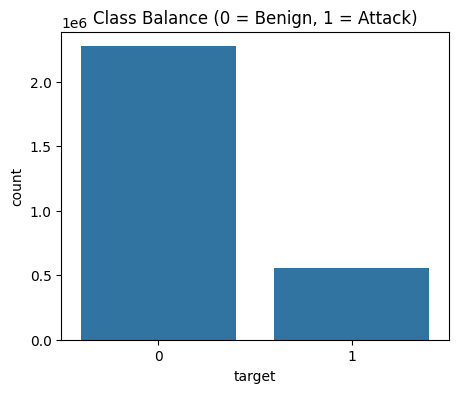

In [39]:
plt.figure(figsize=(5,4))
sns.countplot(x='target', data=df_eda)
plt.title("Class Balance (0 = Benign, 1 = Attack)")
plt.show()


# Plot 1 — Class Balance
This shows how many **benign (0)** and **attack (1)** flows exist.
👉 Often datasets are imbalanced (more benign than attacks), which affects model training.


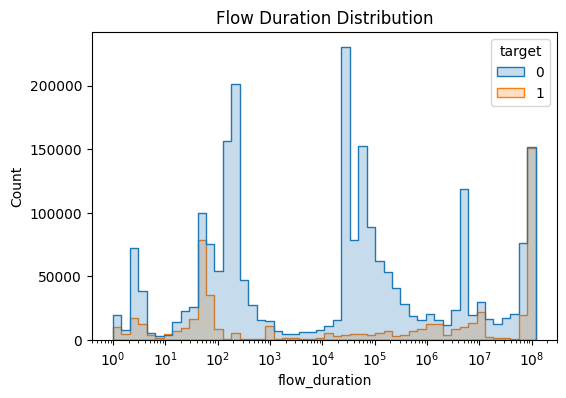

In [40]:
plt.figure(figsize=(6,4))
sns.histplot(data=df_eda, x='flow_duration', hue='target',
             bins=50, log_scale=(True, False), element='step')
plt.title("Flow Duration Distribution")
plt.show()


# Plot 2 — Flow Duration
Attack traffic often has **very short flows** (like DoS floods) or **very long flows** (like infiltration).
Here we compare durations for benign vs attack flows.


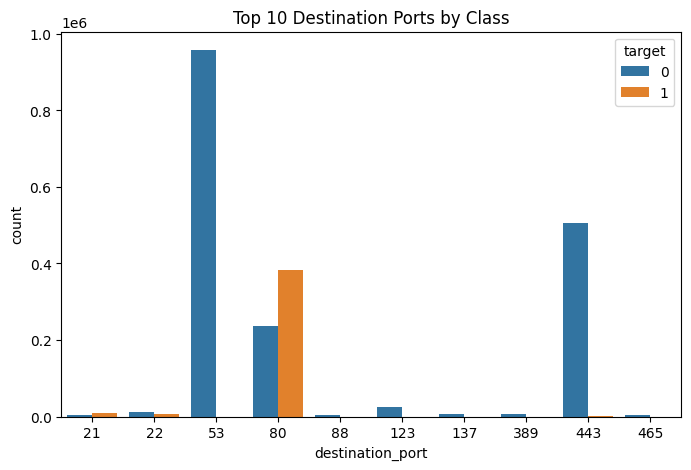

In [41]:
plt.figure(figsize=(8,5))
top_ports = df_eda['destination_port'].value_counts().nlargest(10).index
sns.countplot(data=df_eda[df_eda['destination_port'].isin(top_ports)],
              x='destination_port', hue='target')
plt.title("Top 10 Destination Ports by Class")
plt.show()


# Plot 3 — Destination Ports
Ports reveal which services are being targeted.
👉 Example: 80/443 for web, 22 for SSH, 53 for DNS.
Attackers often focus on specific ports.


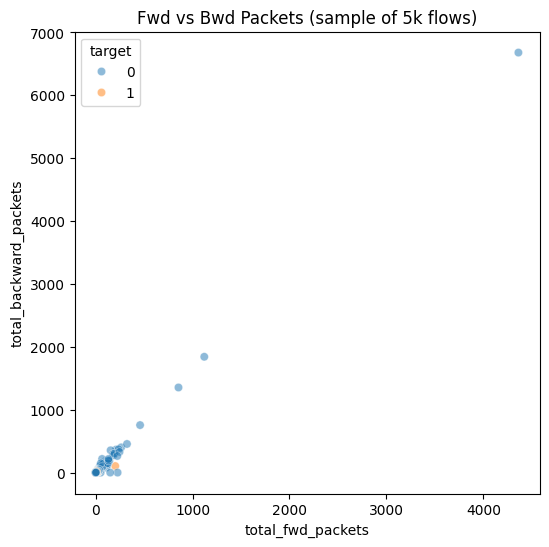

In [42]:
df_sample = df_eda.sample(5000, random_state=42)

plt.figure(figsize=(6,6))
sns.scatterplot(data=df_sample,
                x='total_fwd_packets', y='total_backward_packets',
                hue='target', alpha=0.5)
plt.title("Fwd vs Bwd Packets (sample of 5k flows)")
plt.show()


# Plot 4 — Forward vs Backward Packets
Benign flows usually have **balanced traffic** (client ↔ server).
Attacks (like DoS) may show **many packets in one direction only**.


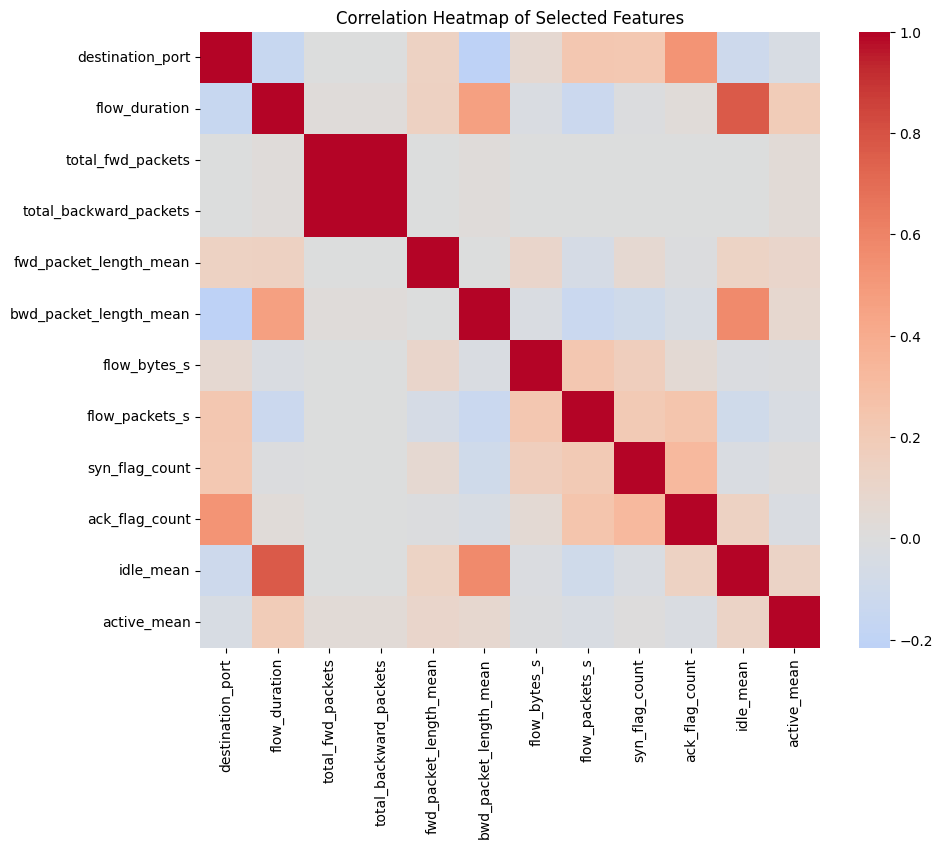

In [43]:
plt.figure(figsize=(10,8))
corr = df_eda[selected_features].corr()
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Selected Features")
plt.show()


# Plot 5 — Correlation Heatmap
Some features are strongly correlated (e.g., packet counts and bytes).
👉 Correlation helps detect **redundant features** we can drop before ML.


# How Attacks Look in Our Selected Features

Here are simple patterns to look for in real attacks:

- **destination_port**  
  - DoS/DDoS → often target common services like 80 (HTTP), 443 (HTTPS).  
  - SSH brute force → port 22.  
  - SQL injection → web ports (80/443).

- **flow_duration**  
  - DoS floods → very short flows (server drops quickly).  
  - Infiltration/data theft → long-lived flows.

- **total_fwd_packets** & **total_backward_packets**  
  - Normal → balanced (client requests, server replies).  
  - DoS → many forward packets, few/no backward packets.  
  - PortScan → many very short forward-only flows.

- **fwd_packet_length_mean** & **bwd_packet_length_mean**  
  - Normal → mix of small requests and bigger replies.  
  - Attack → repetitive small packets (scans/floods) or unusual packet sizes.

- **flow_bytes_s** & **flow_packets_s**  
  - DoS/DDoS → extreme spikes in packets per second.  
  - Data exfiltration → very high bytes per second.  
  - Normal → moderate rates, not sustained.

- **syn_flag_count** & **ack_flag_count**  
  - SYN flood → many SYNs, very few ACKs.  
  - Normal → each SYN usually followed by an ACK.

- **idle_mean**  
  - Normal browsing → idle gaps (user clicks, server waits).  
  - Botnet C2 (command & control) → regular idle gaps (heartbeat traffic).  
  - Flood attacks → very low idle time.

- **active_mean**  
  - DoS/DDoS → long continuous active periods.  
  - Normal → shorter bursts (request, response, pause).


In [48]:
import numpy as np
from sklearn.model_selection import train_test_split

# Clean dataset
X = df_all[selected_features].replace([np.inf, -np.inf], np.nan).fillna(0)
y = df_all['target']

# Sample 20k for workshop speed
df_small = df_all.sample(20000, random_state=42)
X = df_small[selected_features].replace([np.inf, -np.inf], np.nan).fillna(0)
y = df_small['target']

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Empty results DataFrame
metrics_df = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "F1-score"])


In [57]:
X.head()

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,fwd_packet_length_mean,bwd_packet_length_mean,flow_bytes_s,flow_packets_s,syn_flag_count,ack_flag_count,idle_mean,active_mean
746827,53,166,2,2,46.000000,85.0,1.578313e+06,24096.385542,0,0,0.0,0.0
946912,443,61945892,7,7,117.428571,621.0,8.344379e+01,0.226004,0,0,61600000.0,322509.0
2216843,53,31414,2,2,31.000000,59.0,5.729929e+03,127.331763,0,0,0.0,0.0
699389,53,208149,2,2,33.000000,59.0,8.839821e+02,19.217003,0,0,0.0,0.0
1170268,5221,41,1,1,0.000000,6.0,1.463415e+05,48780.487800,0,0,0.0,0.0


In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train
log_reg = LogisticRegression(max_iter=200, class_weight="balanced")
log_reg.fit(X_train_scaled, y_train)

y_pred_lr = log_reg.predict(X_test_scaled)

# Collect metrics
metrics_df.loc[len(metrics_df)] = [
    "Logistic Regression",
    accuracy_score(y_test, y_pred_lr),
    precision_score(y_test, y_pred_lr),
    recall_score(y_test, y_pred_lr),
    f1_score(y_test, y_pred_lr)
]

metrics_df


,Model,Accuracy,Precision,Recall,F1-score
0,Logistic Regression,0.844,0.56672,0.898062,0.694915


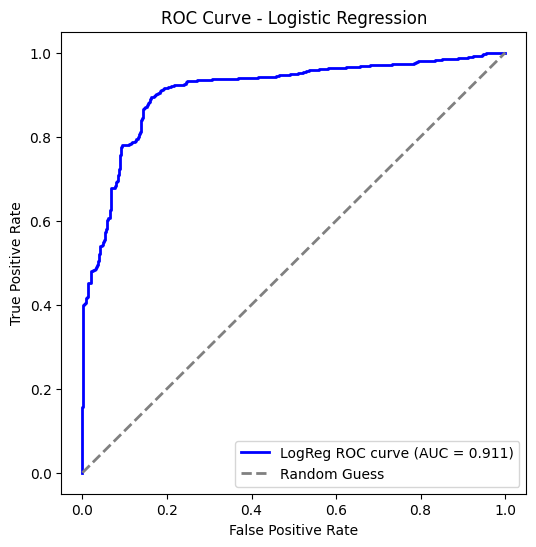

In [50]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities (for positive class = 1)
y_prob_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_lr)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"LogReg ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], color="gray", linestyle="--", lw=2, label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.show()


# Logistic Regression Performance — How to Read the Results

We trained a **Logistic Regression model** on 12 selected flow features.

## 1. Metrics Table
- **Accuracy (0.844)** → Overall, 84% of flows were classified correctly.  
- **Precision (0.567)** → Out of all flows predicted as attacks, ~57% were truly attacks.  
    This shows we still get *false alarms*.  
- **Recall (0.898)** → Out of all actual attacks, ~90% were caught by the model.  
    High recall = good at detecting attacks, even if some false positives slip in.  
- **F1-score (0.695)** → Balance between precision and recall.  
   ~69% shows a decent compromise but not perfect.

## 2. ROC Curve
- **Blue line** → Model performance across thresholds.  
- **Gray dashed line** → Random guessing baseline (AUC = 0.5).  
- **AUC = 0.911** → Our model is **91% good at separating attacks vs benign** traffic.  
   The closer to 1.0, the better.  

## 3. Takeaway for Cybersecurity
- Logistic Regression is a **simple linear model**.  
- It catches most attacks (high recall), but precision is lower → *we still raise too many alerts*.  
- ROC-AUC tells us the model has strong discriminative power.  
- For real-world IDS, we’d want to combine this with more powerful models (e.g., Random Forest) to reduce false positives.


                 Model  Accuracy  Precision    Recall  F1-score   ROC-AUC
0  Logistic Regression  0.844000   0.566720  0.898062  0.694915       NaN
1        Random Forest  0.994167   0.989796  0.980623  0.985188  0.998115


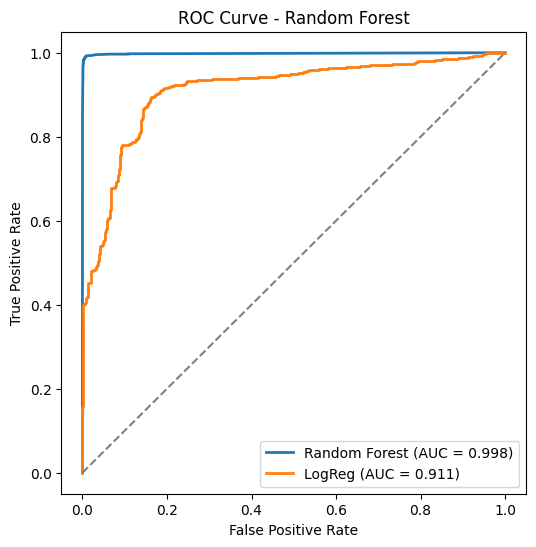

In [54]:
# Simple, defensive RF training + safe append to metrics_df + ROC plot

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd

# Train RF (assumes X_train, X_test, y_train, y_test exist; if not, create them as earlier)
rf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
rf.fit(X_train, y_train)

# Predictions & probs
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# Compute metrics
acc = accuracy_score(y_test, y_pred_rf)
prec = precision_score(y_test, y_pred_rf)
rec = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)
roc_auc = roc_auc_score(y_test, y_prob_rf)

# Ensure metrics_df has exact expected columns
desired_cols = ["Model","Accuracy","Precision","Recall","F1-score","ROC-AUC"]
if 'metrics_df' in globals():
    # reindex to desired cols (will add any missing cols as NaN and drop extras)
    metrics_df = metrics_df.reindex(columns=desired_cols)
else:
    metrics_df = pd.DataFrame(columns=desired_cols)

# Append row safely
metrics_df.loc[len(metrics_df)] = ["Random Forest", acc, prec, rec, f1, roc_auc]

# Print table
print(metrics_df)

# Plot ROC
fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, lw=2, label=f"Random Forest (AUC = {roc_auc:.3f})")
# overlay LogReg if available
try:
    y_prob_lr = log_reg.predict_proba(X_test_scaled)[:,1]
    fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
    auc_lr = auc(fpr_lr, tpr_lr)
    plt.plot(fpr_lr, tpr_lr, lw=2, label=f"LogReg (AUC = {auc_lr:.3f})")
except Exception:
    pass

plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend(loc="lower right")
plt.show()


# Comparing Logistic Regression vs Random Forest

## Logistic Regression
- **Accuracy = 84%** → Correctly classified 84% of flows overall.  
- **Precision = 57%** → Only ~57% of flows flagged as attacks were actually attacks.  
   This means **many false alarms**.  
- **Recall = 90%** → It caught 9 out of 10 attacks.  
   High recall = good at **not missing attacks**, but at the cost of more false positives.  
- **F1 = 69%** → Balance between precision & recall is moderate.  
- **ROC-AUC = 0.91** → The model is 91% good at separating attacks vs benign traffic.

**Takeaway:** Logistic Regression is a simple, interpretable model. It’s good at catching attacks but **triggers too many false positives**, which is noisy in real SOC (Security Operations Center) environments.

---

## Random Forest
- **Accuracy = 99%** → Very high overall correctness.  
- **Precision = 99%** → Almost every predicted attack **is truly an attack**.  
- **Recall = 98%** → It catches nearly all attacks.  
- **F1 = 98%** → Strong balance between precision and recall.  
- **ROC-AUC = 0.998** → Almost perfect separation between benign and attack.

**Takeaway:** Random Forest is much more powerful here. It balances both **catching attacks** and **avoiding false alarms**.  
This makes it closer to a real-world IDS candidate.

---

## Big Picture
- Logistic Regression = **baseline** (easy to explain, weaker performance).  
- Random Forest = **stronger model** (less interpretable but much better accuracy).  
- In real-world IDS, a mix of models is often used: interpretable models for quick insights, and complex ensembles for high accuracy.


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [02:10:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                 Model  Accuracy  Precision    Recall  F1-score   ROC-AUC
0  Logistic Regression  0.844000   0.566720  0.898062  0.694915       NaN
1        Random Forest  0.994167   0.989796  0.980623  0.985188  0.998115
2              XGBoost  0.994000   0.981590  0.988206  0.984887  0.999276


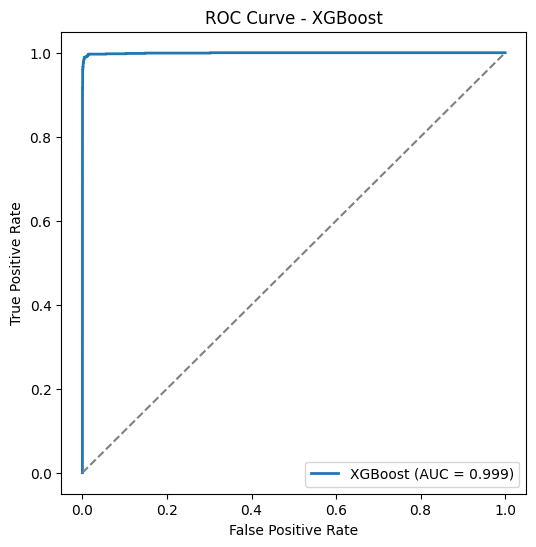

In [55]:
!pip install xgboost -q

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Train XGBoost (on sampled dataset for speed)
xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),  # handle imbalance
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)

xgb.fit(X_train, y_train)

# Predictions & probabilities
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred_xgb)
prec = precision_score(y_test, y_pred_xgb)
rec = recall_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb)
roc_auc = roc_auc_score(y_test, y_prob_xgb)

# Add to metrics_df
metrics_df.loc[len(metrics_df)] = ["XGBoost", acc, prec, rec, f1, roc_auc]

# Show updated table
print(metrics_df)

# Plot ROC
fpr, tpr, _ = roc_curve(y_test, y_prob_xgb)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, lw=2, label=f"XGBoost (AUC = {roc_auc:.3f})")
plt.plot([0,1],[0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend(loc="lower right")
plt.show()


# Model Comparison — Interpretation

## Logistic Regression
- **Accuracy = 84%**
- **Recall = 90%** → good at catching attacks.  
- **Precision = 57%** → many false positives (too many benign flows flagged as attacks).  
- **F1 = 69%** → weak balance between precision & recall.  
- **ROC-AUC = 0.91** → the model can separate classes reasonably well.  

➡️ Takeaway: Logistic Regression is a **good baseline**. It explains features clearly, but produces too many false alarms for real-world IDS.

---

## Random Forest
- **Accuracy = 99.4%**
- **Precision = 99%** → almost no false alarms.  
- **Recall = 98%** → catches almost all attacks.  
- **F1 = 98%** → strong balance.  
- **ROC-AUC = 0.998** → excellent separation of benign vs attack.  

➡️ Takeaway: Random Forest is a **powerful and reliable** choice. It balances high detection with low false positives.

---

## XGBoost (Gradient Boosting)
- **Accuracy = 99.4%**
- **Precision = 98%**, **Recall = 99%**, **F1 = 98%** → almost perfect balance.  
- **ROC-AUC = 0.999** → nearly perfect separation.  

➡️ Takeaway: XGBoost is **state-of-the-art** for tabular intrusion data. It improves slightly on Random Forest and is widely used in security competitions and production IDS.

---

## Big Picture
- Logistic Regression → **teachable baseline** (linear, interpretable).  
- Random Forest → **strong general model** (robust, easy to explain).  
- XGBoost → **best performance** (industry standard for accuracy).  

For workshop teaching:
- Start with Logistic Regression → explain linear decision making.  
- Move to Random Forest → show how trees “vote.”  
- End with XGBoost → highlight how boosting pushes performance to near perfection.


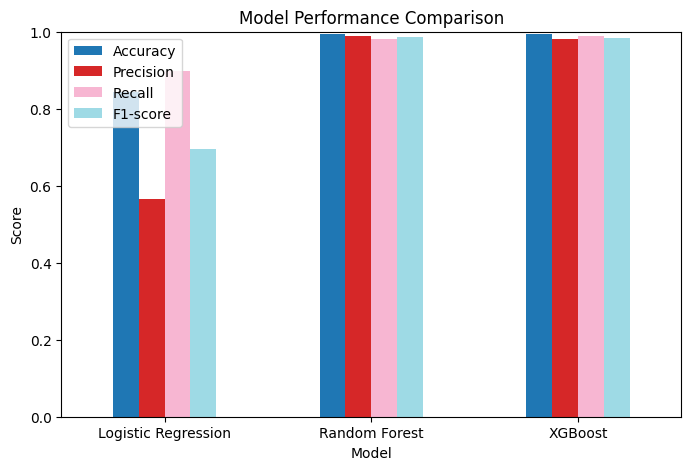

In [58]:
metrics_df.set_index("Model")[["Accuracy","Precision","Recall","F1-score"]].plot(
    kind="bar", figsize=(8,5), ylim=(0,1), rot=0, colormap="tab20"
)
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.show()


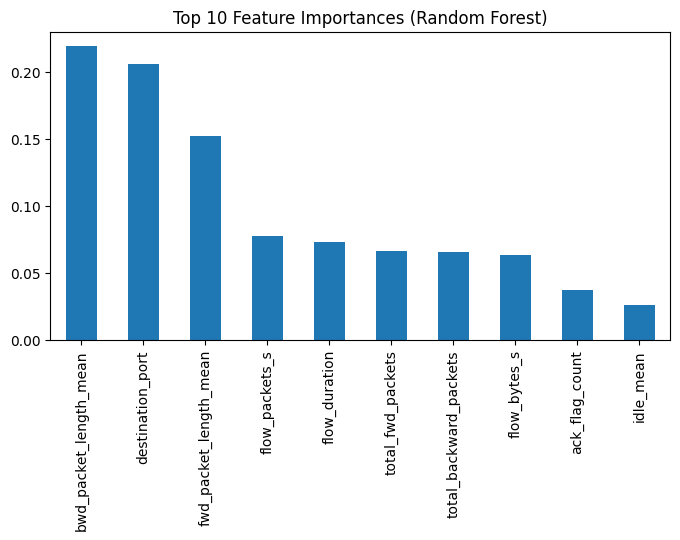

In [59]:
import pandas as pd
import matplotlib.pyplot as plt

importances = pd.Series(rf.feature_importances_, index=selected_features)
importances.sort_values(ascending=False).head(10).plot(kind="bar", figsize=(8,4))
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()


In [61]:
import joblib
import os

# Define save path
save_path = "/content/drive/MyDrive/cybersecurity_data/MachineLearning"

# Make sure the folder exists
os.makedirs(save_path, exist_ok=True)

# Save models
joblib.dump(log_reg, os.path.join(save_path, "logistic_regression.joblib"))
joblib.dump(rf, os.path.join(save_path, "random_forest.joblib"))
joblib.dump(xgb, os.path.join(save_path, "xgboost.joblib"))

print("✅ Models saved in:", save_path)


✅ Models saved in: /content/drive/MyDrive/cybersecurity_data/MachineLearning


In [ ]:
pip install gradio

In [62]:
import gradio as gr
import joblib
import pandas as pd
import os

# Path to saved model
model_path = "/content/drive/MyDrive/cybersecurity_data/MachineLearning/random_forest.joblib"

# Load Random Forest model
rf_model = joblib.load(model_path)

# Feature list (must match training order)
selected_features = [
    'destination_port',
    'flow_duration',
    'total_fwd_packets',
    'total_backward_packets',
    'fwd_packet_length_mean',
    'bwd_packet_length_mean',
    'flow_bytes_s',
    'flow_packets_s',
    'syn_flag_count',
    'ack_flag_count',
    'idle_mean',
    'active_mean'
]

# Prediction function
def predict_attack(dest_port, flow_dur, fwd_pkts, bwd_pkts, fwd_len_mean, bwd_len_mean,
                   flow_bytes_s, flow_pkts_s, syn_count, ack_count, idle_mean, active_mean):
    # Put into dataframe
    x = pd.DataFrame([[dest_port, flow_dur, fwd_pkts, bwd_pkts, fwd_len_mean, bwd_len_mean,
                       flow_bytes_s, flow_pkts_s, syn_count, ack_count, idle_mean, active_mean]],
                     columns=selected_features)
    pred = rf_model.predict(x)[0]
    return "🚨 Attack" if pred == 1 else "✅ Benign"

# Build Gradio UI
demo = gr.Interface(
    fn=predict_attack,
    inputs=[
        gr.Number(label="Destination Port"),
        gr.Number(label="Flow Duration"),
        gr.Number(label="Total Fwd Packets"),
        gr.Number(label="Total Bwd Packets"),
        gr.Number(label="Fwd Packet Length Mean"),
        gr.Number(label="Bwd Packet Length Mean"),
        gr.Number(label="Flow Bytes/s"),
        gr.Number(label="Flow Packets/s"),
        gr.Number(label="SYN Flag Count"),
        gr.Number(label="ACK Flag Count"),
        gr.Number(label="Idle Mean"),
        gr.Number(label="Active Mean")
    ],
    outputs="text",
    title="Intrusion Detection Demo",
    description="Enter flow features to predict if the traffic is Benign or Attack"
)

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://919d8dc863b277f303.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [60]:
import gradio as gr

def predict_attack(dest_port, flow_dur, fwd_pkts, bwd_pkts, fwd_len_mean, bwd_len_mean, flow_bytes_s, flow_pkts_s, syn_count, ack_count, idle_mean, active_mean):
    x = pd.DataFrame([[dest_port, flow_dur, fwd_pkts, bwd_pkts, fwd_len_mean, bwd_len_mean,
                       flow_bytes_s, flow_pkts_s, syn_count, ack_count, idle_mean, active_mean]],
                     columns=selected_features)
    pred = rf.predict(x)[0]   # use RF model for demo
    return "Attack" if pred == 1 else "Benign"

demo = gr.Interface(
    fn=predict_attack,
    inputs=[
        gr.Number(label="Destination Port"), gr.Number(label="Flow Duration"),
        gr.Number(label="Total Fwd Packets"), gr.Number(label="Total Bwd Packets"),
        gr.Number(label="Fwd Packet Length Mean"), gr.Number(label="Bwd Packet Length Mean"),
        gr.Number(label="Flow Bytes/s"), gr.Number(label="Flow Packets/s"),
        gr.Number(label="SYN Flag Count"), gr.Number(label="ACK Flag Count"),
        gr.Number(label="Idle Mean"), gr.Number(label="Active Mean")
    ],
    outputs="text"
)
demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c14b1305eb53672771.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [64]:
import os
import joblib

# Define new folder path
save_path = "/content/drive/MyDrive/cybersecurity_data/PreparedData"
os.makedirs(save_path, exist_ok=True)

# Select features + label, clean infinities/NaNs
X = df_all[selected_features].replace([np.inf, -np.inf], np.nan).fillna(0)
y = df_all['target']

# Save them
joblib.dump(X, os.path.join(save_path, "X_selected.joblib"))
joblib.dump(y, os.path.join(save_path, "y_labels.joblib"))

print("✅ Saved X and y in:", save_path)


✅ Saved X and y in: /content/drive/MyDrive/cybersecurity_data/PreparedData
